# Understanding CUDA

![image](https://images.unsplash.com/photo-1624701928517-44c8ac49d93c?w=800&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8M3x8R1BVfGVufDB8fDB8fHww)

CUDA is the interface between logic and NVIDIA GPUs. It is a great way to utilize NVIDIA GPUs to achieve massively parallel tensor computing!

I always like to think of paralellisation in compute similar to an optimization problem in manual labour. If we can get 5 people to dig a hole in the ground, why not use all?

While CPUs and also achieve parallelisation, GPUs are much better designed for it - due to their ability to spin up Ts and Ms of "threads" which make the similar, independent computations in parallel.

Since I am on a Mac (no NVIDIA), I'll utilize colab and pytorch's easy "CUDA inline" functionality to learn and explore CUDA parallelization.

In [1]:
import torch
from PIL import Image
import requests
import torchvision.transforms as transforms
from io import BytesIO
import matplotlib.pyplot as plt
import math

In [2]:
img_url = 'https://images.unsplash.com/photo-1465146344425-f00d5f5c8f07?w=800&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MTh8fG5hdHVyZXxlbnwwfHwwfHx8MA%3D%3D'

In [3]:
def get_image(url):
  return Image.open(BytesIO(requests.get(url).content))

def tensor(image):
  transform = transforms.Compose([
      transforms.PILToTensor()])
  return transform(image)



def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [4]:
image = get_image(img_url)

# Transforming PIL Image to Torch Tensor

In [5]:
image = tensor(image)

In [6]:
image.shape

torch.Size([3, 530, 800])

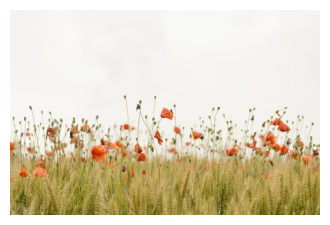

In [7]:
show_img(image)

# Converting Image to Grayscale

We have a simple matrix transformation to convert coloured images to grayscale.
Each pixel index in each channel needs the following transformation ->

  0.2989*red_c + 0.5870*green_c + 0.1140*blue_c



In [8]:
c, h, w = image.shape
flatImage = image.flatten()
n = h*w
res = torch.empty(n, dtype=image.dtype)

In [9]:
%%time
for i in range(n):
  res[i] = 0.2989*flatImage[i] + 0.5870*flatImage[i+n] + 0.1140*flatImage[i+(2*n)]

CPU times: user 18.4 s, sys: 53.5 ms, total: 18.4 s
Wall time: 18.6 s


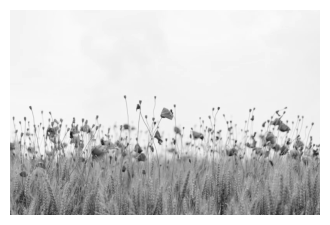

In [10]:
show_img(res.view(h,w), cmap='gray')

# Interpreting this action through "blocks" and "threads"

GPUs work with threads and thread blocks for prallelisation.
Although we won't achieve parallels here, we will still schematically reach the point where we have multiple blocks with threads making individual calculations.

In [11]:
threads = 256
blocks = math.ceil(n / 256)

## Picturing the blocks

Imagine there are 256 threads trying to calculate some task. Since our image has >10k pixels, we'll need as many threads. We find how many blocks of these we need, turns out to be 1657.
Let's write a CPU logic which will make the calculations in these blocks (this is still not parallel computing)

In [12]:
res_b = torch.empty(n, dtype = image.dtype)

In [13]:
%%time

for block in range(blocks):
  for thread in range(threads):
    i = block*threads + thread # gives us the thread index or here pixel
    if(i<n):
      res_b[i] = 0.2989*flatImage[i] + 0.5870*flatImage[i+n] + 0.1140*flatImage[i+(2*n)]

CPU times: user 17.9 s, sys: 72.3 ms, total: 18 s
Wall time: 18 s


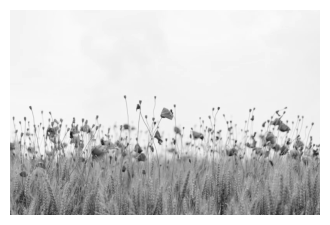

In [14]:
show_img(res_b.view(h,w), cmap='gray')

It is taking around 20s on a CPU to compute the grayscale image!
This is a lot. Now let's try to write a CUDA "Kernel" to achieve this task in parallel - thereby speeding things up!

# CUDA :: Kernel

In [15]:
import os
from torch.utils.cpp_extension import load_inline
os.environ['CUDA_LAUNCH_BLOCKING']='1'
!pip3 install wurlitzer
%load_ext wurlitzer


def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")


cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [30]:
cuda_src = cuda_begin + r'''
__global__ void grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    //This is the CUDA logic
    int idx = blockIdx.x * blockDim.x + threadIdx.x; // Thread index

    if (idx < n) {
        // Calculate indices for accessing R, G, and B components of pixel
        int r_idx = idx;
        int g_idx = idx + n;
        int b_idx = idx + 2 * n;

        // Convert RGB to grayscale using specified weights
        out[idx] = 0.2989 * x[r_idx] + 0.5870 * x[g_idx] + 0.1140 * x[b_idx];
    }
}

    // Kernels are async, and not supposed to return any outputs! Only transform them.
    // Define torch function to use this kernel.
torch::Tensor convert_to_grayscale(torch::Tensor input){
  CHECK_INPUT(input);
  int h = input.size(1);
  int w = input.size(2);
  int n = h*w;
  auto output = torch::empty({h,w}, input.options());
  int threads = 256;

  grayscale_kernel<<<cdiv(n, threads), threads>>>(
    input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), n);
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return output;
}'''

In [29]:
!pip3 install ninja
cpp_src = "torch::Tensor convert_to_grayscale(torch::Tensor input);"
module = load_cuda(cuda_src, cpp_src, ['convert_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 3 and re-building as inline_ext_v3...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext_v3...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/i

Loading extension module inline_ext_v3...


In [22]:
[o for o in dir(module) if o[0]!='_']

['convert_to_grayscale']

In [25]:
image_cuda = image.contiguous().cuda()

In [26]:
%%time
res_cuda = module.convert_to_grayscale(image_cuda).cpu()

CPU times: user 818 µs, sys: 995 µs, total: 1.81 ms
Wall time: 3.74 ms


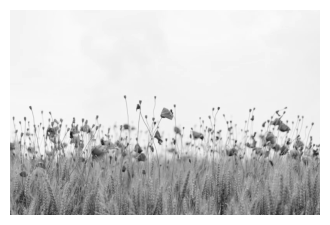

In [27]:
show_img(res_cuda, cmap='gray')